<a href="https://colab.research.google.com/github/mcalmeida13/My_Projects/blob/master/Brazilian_rent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brazilian rent price: Data analysis

## Motivation
This notebook is going to be focused on solving the problem of predicting house rent in five cities of Brazil.

A house value is simply more than location and square footage. We are going to take advantage of all of the feature variables available to use and use it to analyze and predict house rent prices.

We are going to break everything into logical steps that allow us to ensure the cleanest, most realistic data for our model to make accurate predictions from.

## Understanding the Client and their Problem

A benefit to this study is that we can have two clients at the same time! (Think of being a divorce lawyer for both interested parties) However, in this case, we can have both clients with no conflict of interest!

Client Housebuyer: This client wants to find their next dream home with a reasonable price tag. They have their locations of interest ready. Now, they want to know if the house price matches the house value. With this study, they can understand which features (ex. Number of bathrooms, location, etc.) influence the final price of the house. If all matches, they can ensure that they are getting a fair price.

Client Houseseller: Think of the average house-flipper. This client wants to take advantage of the features that influence a house price the most. They typically want to buy a house at a low price and invest on the features that will give the highest return. For example, buying a house at a good location but small square footage. The client will invest on making rooms at a small cost to get a large return.
Data

Our data comes from a Kaggle competition named “brazilian_houses_to_rent”, which is a dataset houses to rent in diferents cities in Brazil.
It contains 10962 training data points and 13 features that might help us predict the selling price of a house.

## Loading Data and Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [19]:
filename = "/content/drive/My Drive/Data Science/Projects/Brazilian Rent/datasets_554905_1035602_houses_to_rent_v2.csv"

In [20]:
df = pd.read_csv(filename)

# take a look at the dataset
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


## Unique cities

In [22]:
cities = df['city'].unique()
cities

array(['São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas',
       'Belo Horizonte'], dtype=object)

## Prices

In [23]:
df['total (R$)'].describe().apply(lambda x: format(x, 'f'))

count      10692.000000
mean        5490.487000
std        16484.725912
min          499.000000
25%         2061.750000
50%         3581.500000
75%         6768.000000
max      1120000.000000
Name: total (R$), dtype: object

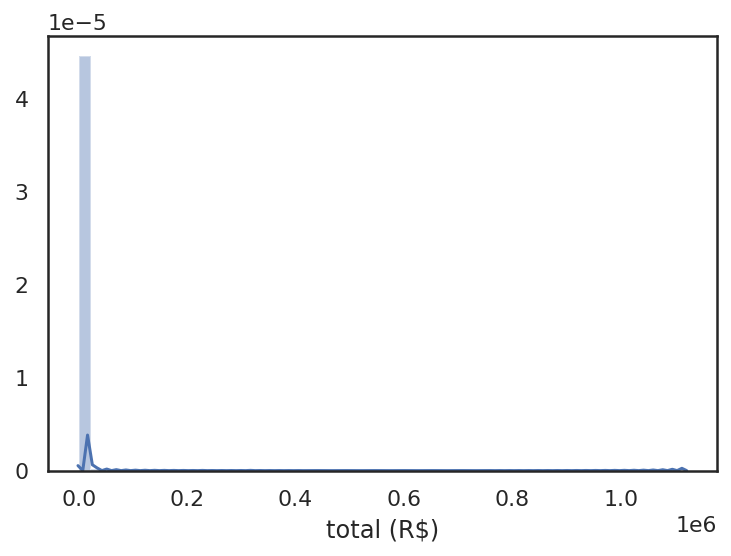

In [24]:
sns.distplot(df['total (R$)']);

It seems a very strange price distribuiton. Existe preços muito altos, prém são preços 'fora da curva'. Vamos identifica-los

In [25]:
big_price = df[df['total (R$)'] > 50000]
big_price

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
255,Belo Horizonte,155,1,4,0,4,not acept,not furnished,1117000,2790,64,38,1120000
2182,São Paulo,700,4,7,8,-,acept,not furnished,0,45000,8750,677,54430
2859,São Paulo,285,4,5,4,6,acept,furnished,200000,20000,1834,254,222100
2928,Rio de Janeiro,35,1,1,0,1,acept,furnished,81150,4500,9900,58,95610
6230,São Paulo,340,5,4,2,7,acept,not furnished,220000,12000,1000,153,233200
6645,São Paulo,42,1,2,1,6,not acept,not furnished,690,2500,313700,32,316900
6979,Belo Horizonte,155,1,4,0,4,not acept,not furnished,1117000,2790,64,38,1120000


Vemos que são apenas 7 casa. Além disso, 255 e 6979 parecem ser o mesmo dado. Vamos retirar esses 7 dados da tabela

In [26]:
df_clean = df.drop(big_price.index)

In [27]:
df_clean['total (R$)'].describe()

count    10685.000000
mean      5198.132616
std       4473.376271
min        499.000000
25%       2061.000000
50%       3578.000000
75%       6758.000000
max      32750.000000
Name: total (R$), dtype: float64

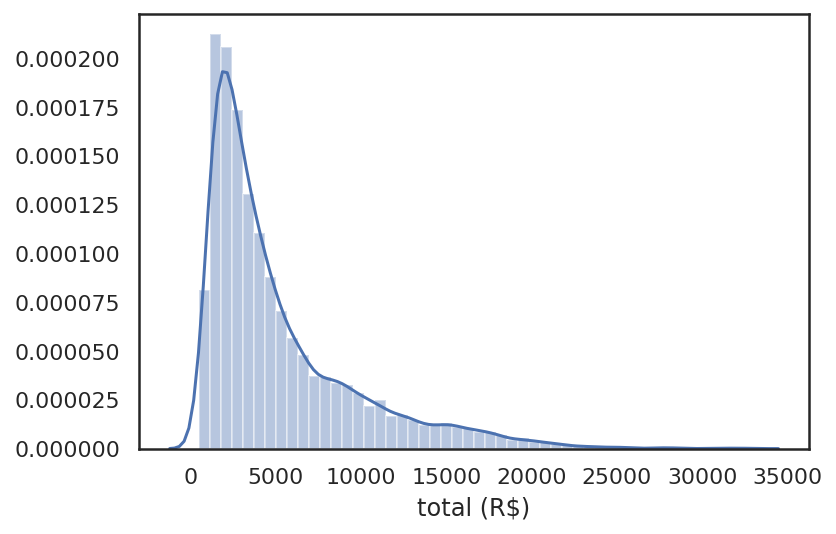

In [28]:
sns.distplot(df_clean['total (R$)']);


 mu = 5198.13 and sigma = 4473.17



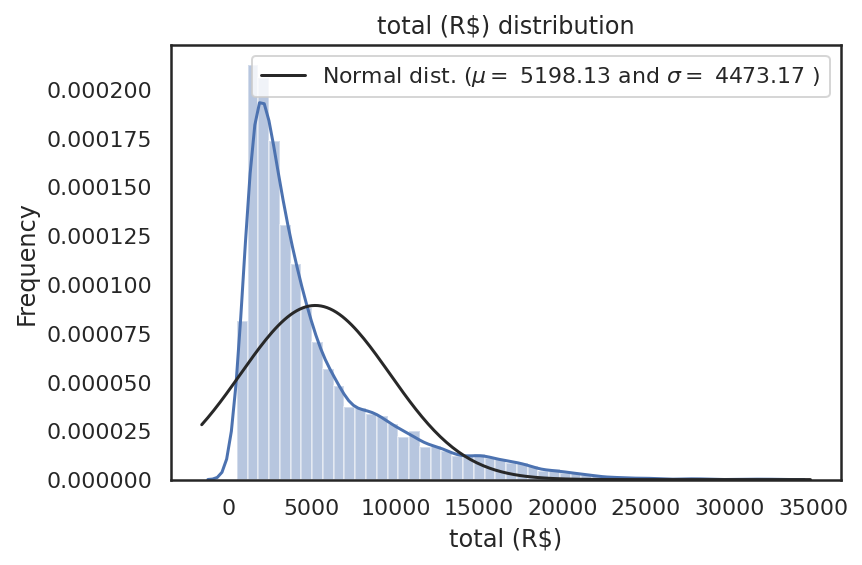

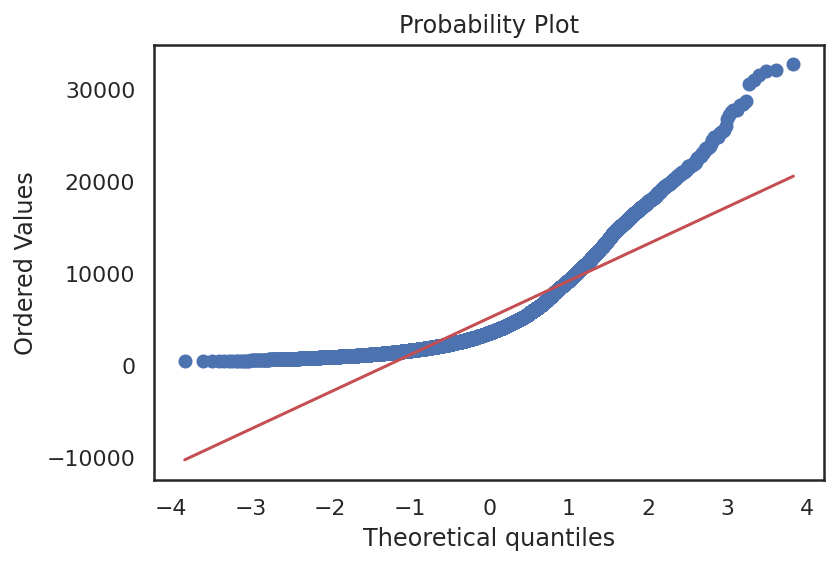

Skewness: 1.736604
Kurtosis: 3.208330


In [29]:
sns.distplot(df_clean['total (R$)'], fit=norm);

(mu, sigma) = norm.fit(df_clean['total (R$)'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('total (R$) distribution')

fig = plt.figure()
res = stats.probplot(df_clean['total (R$)'], plot=plt)
plt.show()

print("Skewness: %f" % df_clean['total (R$)'].skew())
print("Kurtosis: %f" % df_clean['total (R$)'].kurt())

Looks like a normal distribution? Not quite! Looking at the kurtosis score, we can see that there is a very nice peak. However, looking at the skewness score, we can see that the sale prices deviate from the normal distribution. Going to have to fix this later! We want our data to be as "normal" as possible.

## Missing data

In [30]:
total = df.isnull().sum().sort_values(ascending=False)
total


total (R$)             0
fire insurance (R$)    0
property tax (R$)      0
rent amount (R$)       0
hoa (R$)               0
furniture              0
animal                 0
floor                  0
parking spaces         0
bathroom               0
rooms                  0
area                   0
city                   0
dtype: int64

No missing data! But is it true?

In [31]:
df_clean['floor'].value_counts()

-      2460
1      1080
2       985
3       931
4       746
5       600
6       537
7       496
8       490
9       369
10      357
11      303
12      257
13      200
14      170
15      147
16      109
17       96
18       75
19       53
20       44
21       42
23       25
25       25
22       24
26       20
24       19
27        8
28        6
29        5
32        2
51        1
35        1
46        1
301       1
Name: floor, dtype: int64

We have 2461 a strange value '-'

In [32]:
df_floor = df_clean[df_clean['floor'] == '-']
df_floor['total (R$)'].describe()

count     2460.00000
mean      5577.70813
std       4613.54099
min        499.00000
25%       1955.25000
50%       4110.00000
75%       7990.00000
max      32040.00000
Name: total (R$), dtype: float64

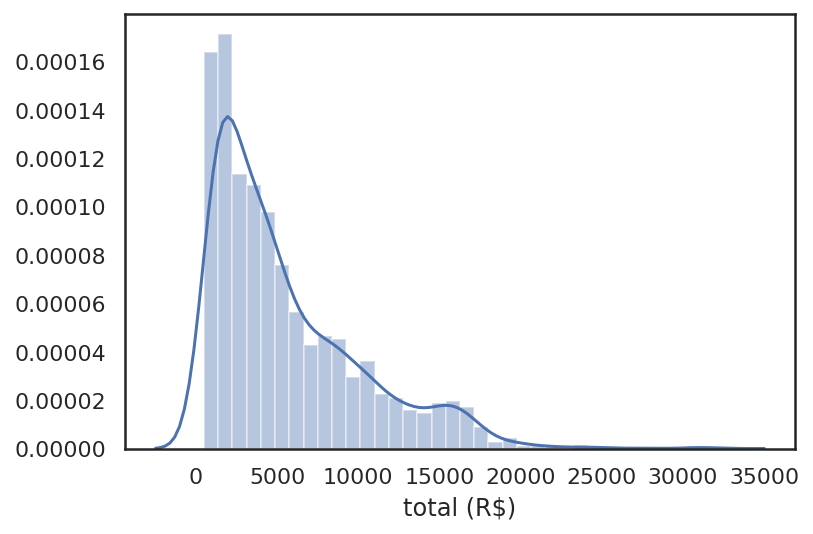

In [33]:
sns.distplot(df_floor['total (R$)']);

## Kind of Data

In [34]:
df_clean.select_dtypes(include=['object']).columns

Index(['city', 'floor', 'animal', 'furniture'], dtype='object')

In [35]:
df_clean.select_dtypes(include=['int64','float64']).columns

Index(['area', 'rooms', 'bathroom', 'parking spaces', 'hoa (R$)',
       'rent amount (R$)', 'property tax (R$)', 'fire insurance (R$)',
       'total (R$)'],
      dtype='object')

# Variables 

### Area vs Price

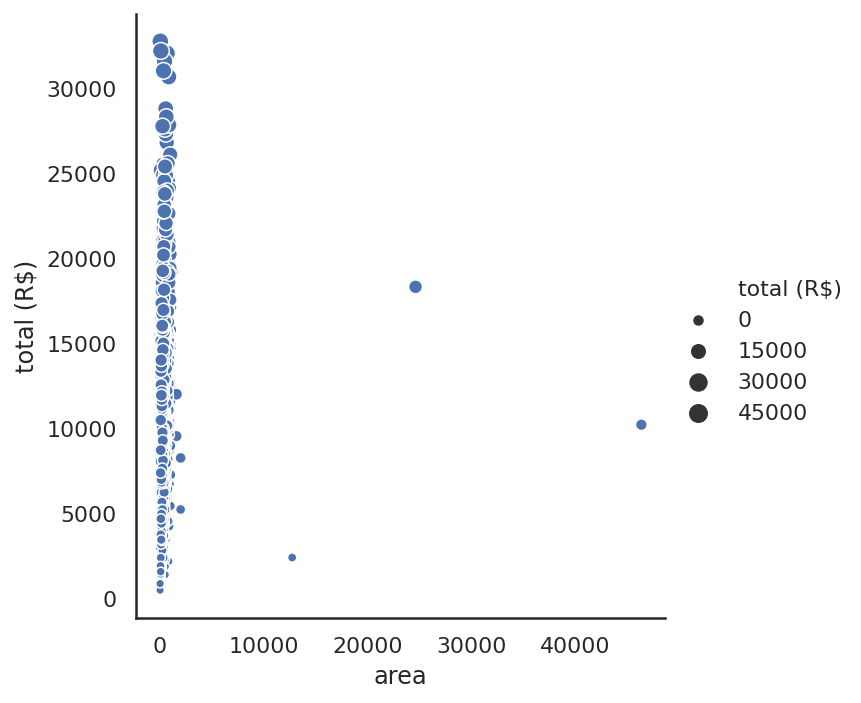

In [36]:
sns.relplot(x = 'area',y='total (R$)',data=df_clean,kind='scatter',size='total (R$)')

Again, here we have some problems, there are some strange data. Let's find and drop them.

In [37]:
big_area = df_clean[df_clean['area'] > 8000]
df_clean_v2 = df_clean.drop(big_area.index)

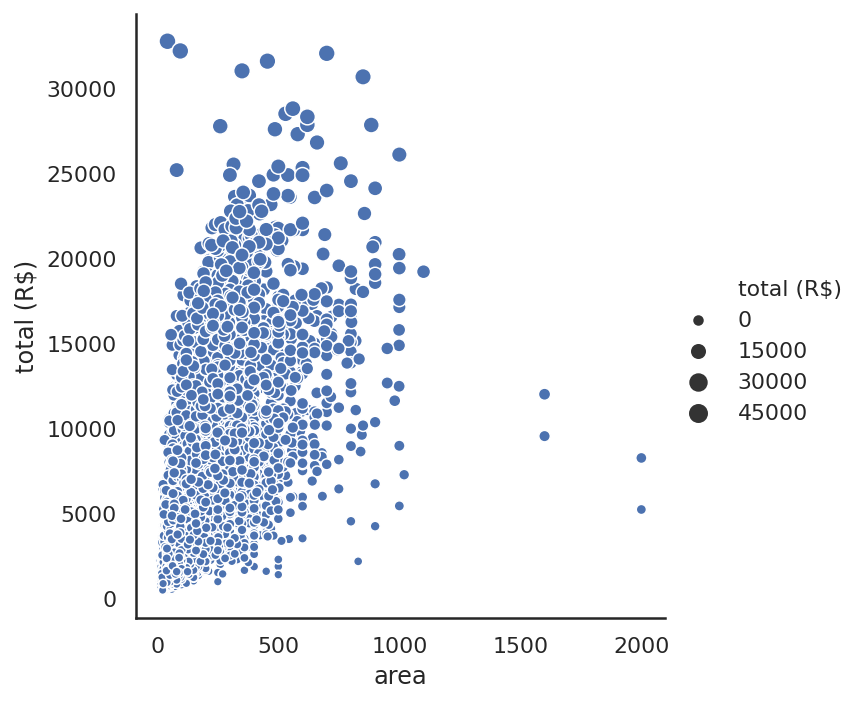

In [38]:
sns.relplot(x = 'area',y='total (R$)',data=df_clean_v2,kind='scatter',size='total (R$)')

You might’ve expected that larger living area should mean a higher price.

### City vs Price

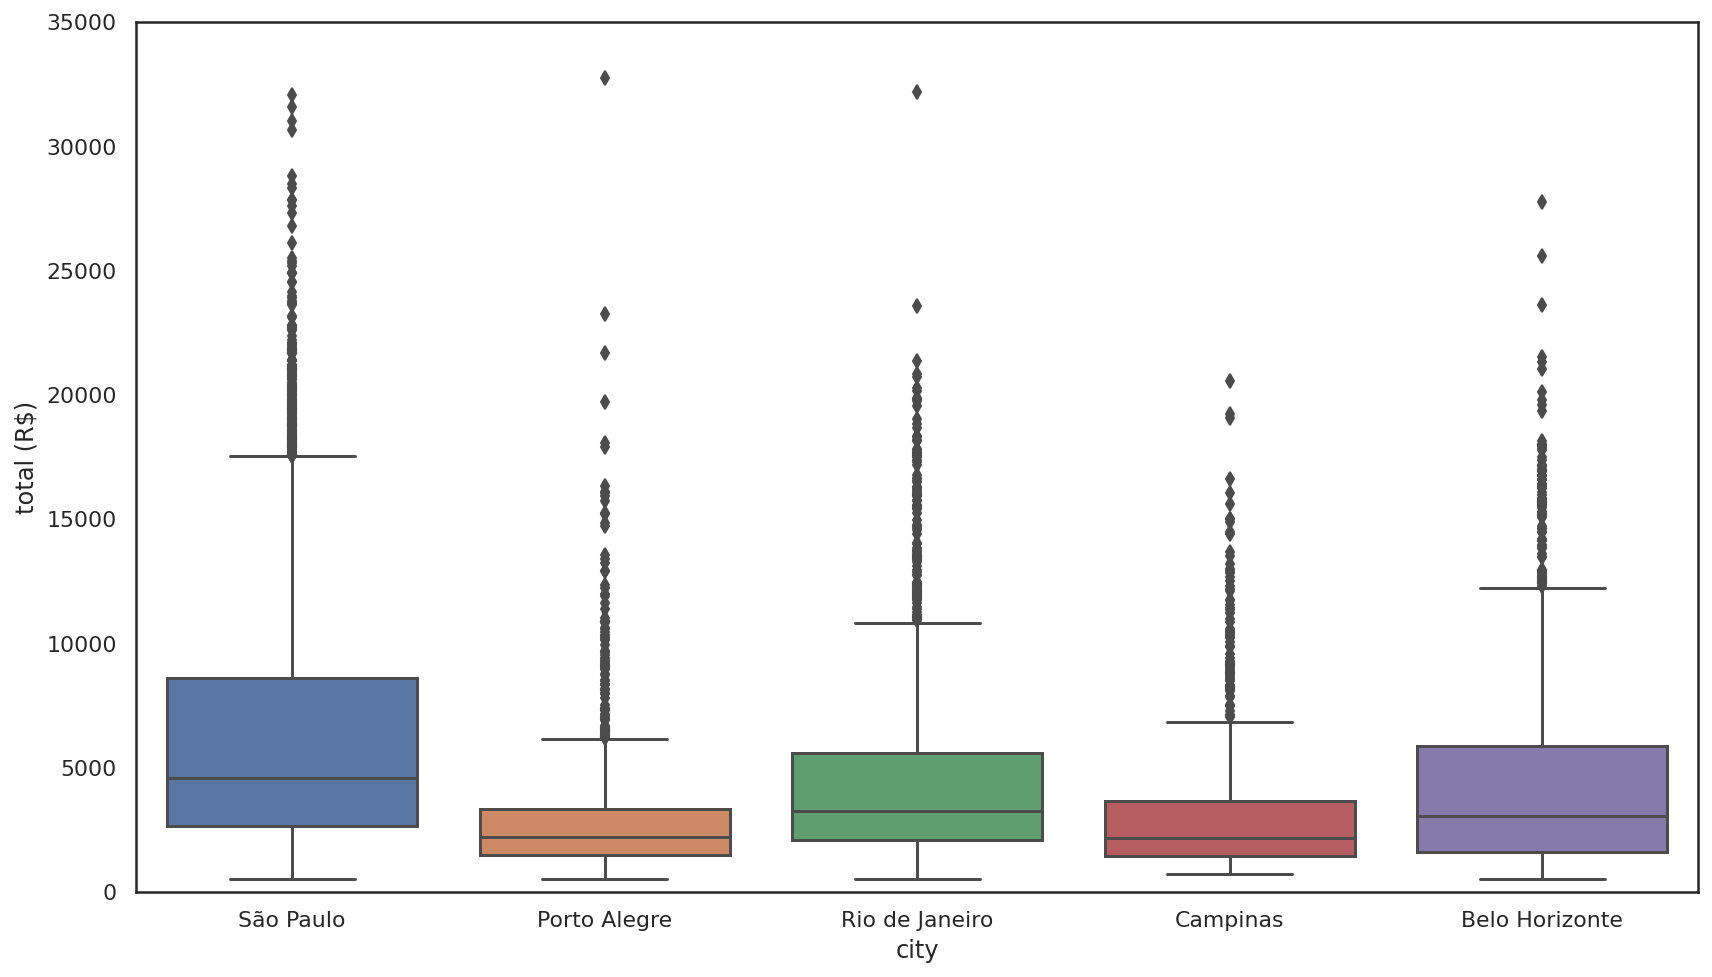

In [39]:
var = 'city'
data = pd.concat([df_clean_v2['total (R$)'], df_clean_v2[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v2)
fig.axis(ymin=0, ymax=35000);

Claramente, São paulo tem uma média de preço maior que as outras cidade

### Rooms vs Price

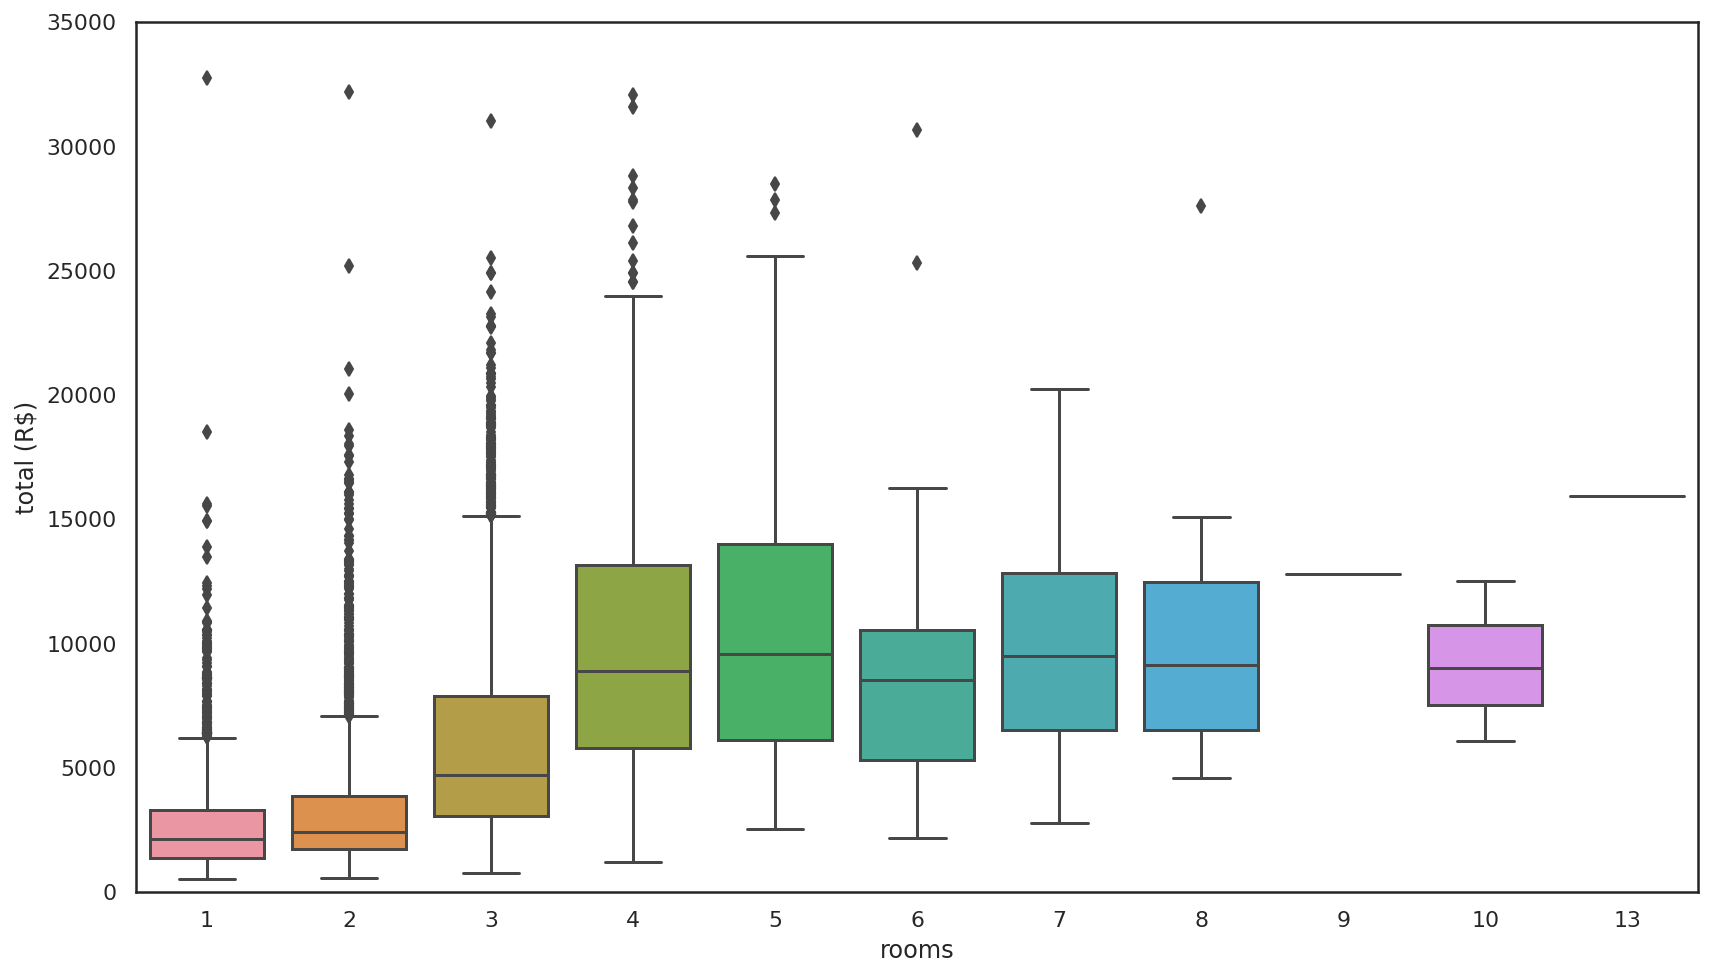

In [40]:
var = 'rooms'
data = pd.concat([df_clean_v2['total (R$)'], df_clean_v2[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v2)
fig.axis(ymin=0, ymax=35000);

### Animal vs Price

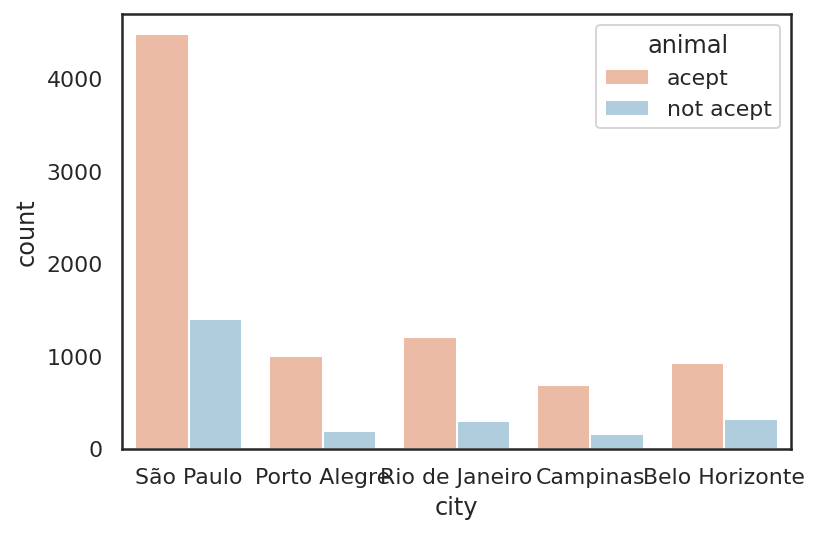

In [41]:
plt.figure()
sns.countplot(x='city', hue='animal', data=df_clean_v2, palette='RdBu')
plt.xticks([0,1,2,3,4], cities)
plt.show()
#gostara de fazer um gráfico barra de cada cidade escrevendo numero de aceitações e nã aceitações

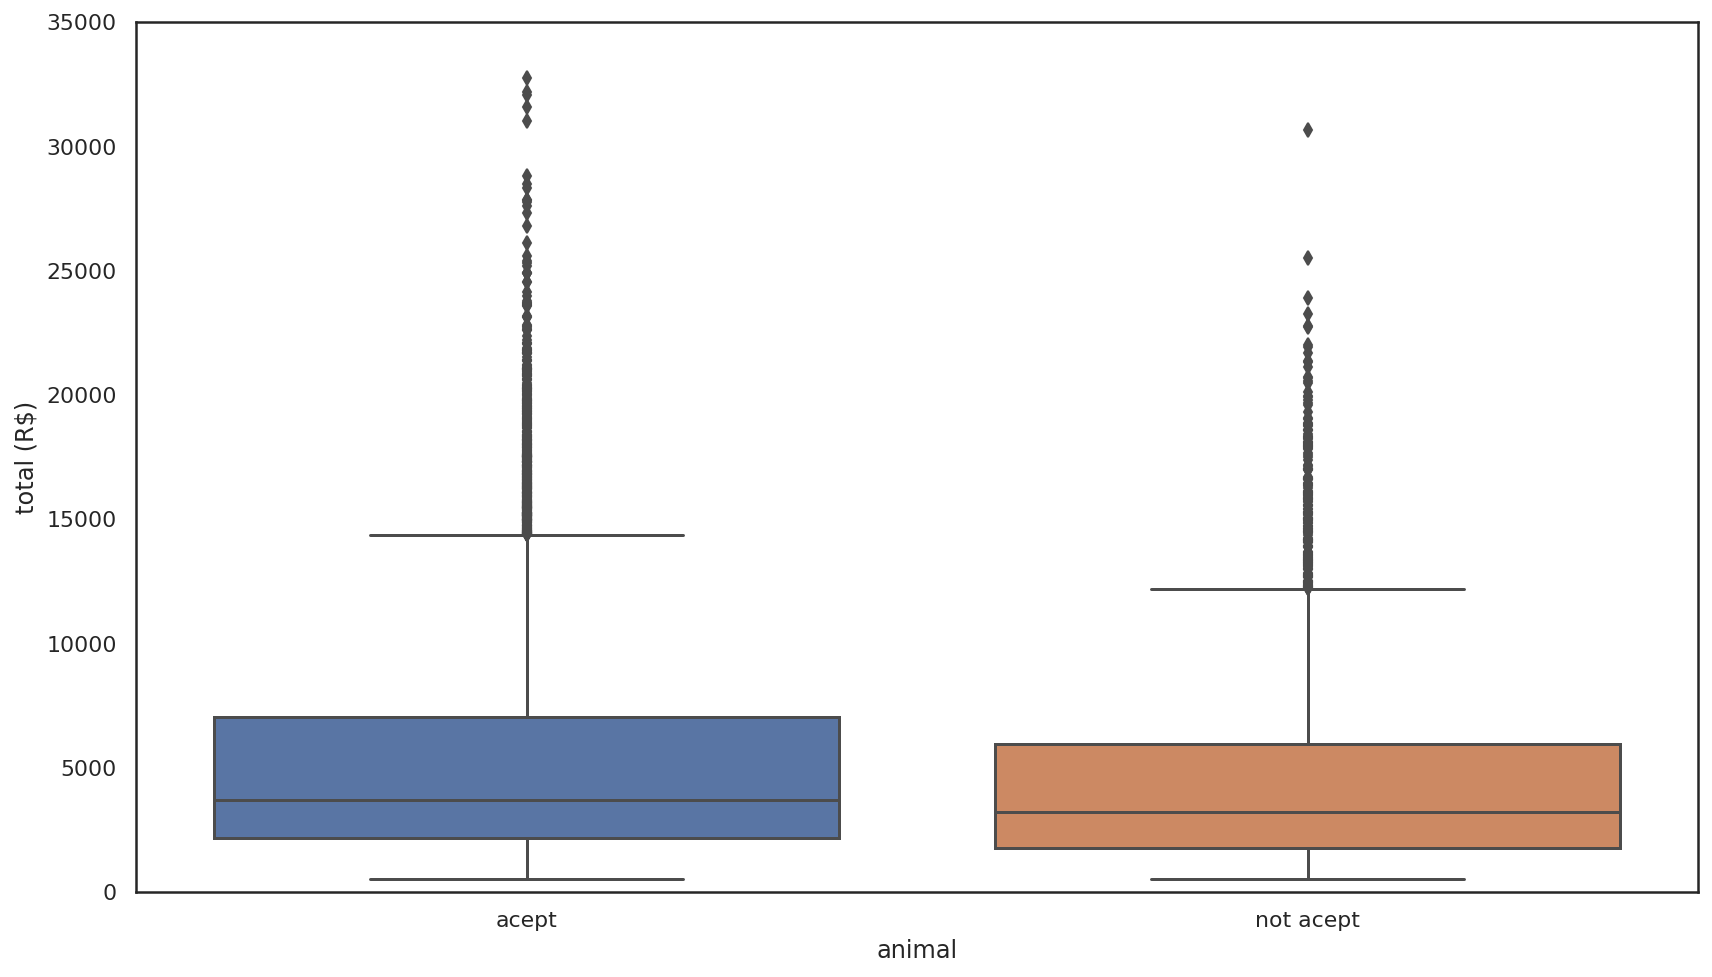

In [42]:
var = 'animal'
data = pd.concat([df_clean_v2['total (R$)'], df_clean_v2[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v2)
fig.axis(ymin=0, ymax=35000);

### Furniture vs Price

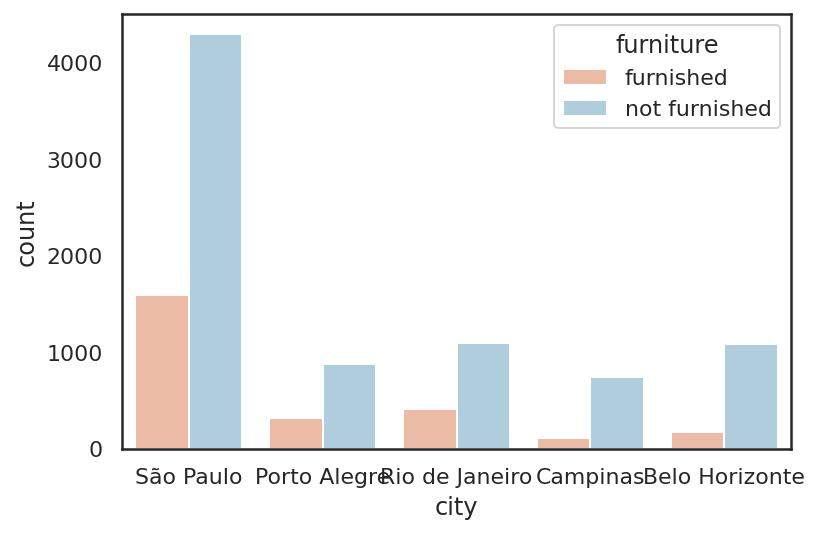

In [43]:
plt.figure()
sns.countplot(x='city', hue='furniture', data=df, palette='RdBu')
plt.xticks([0,1,2,3,4], cities)
plt.show()

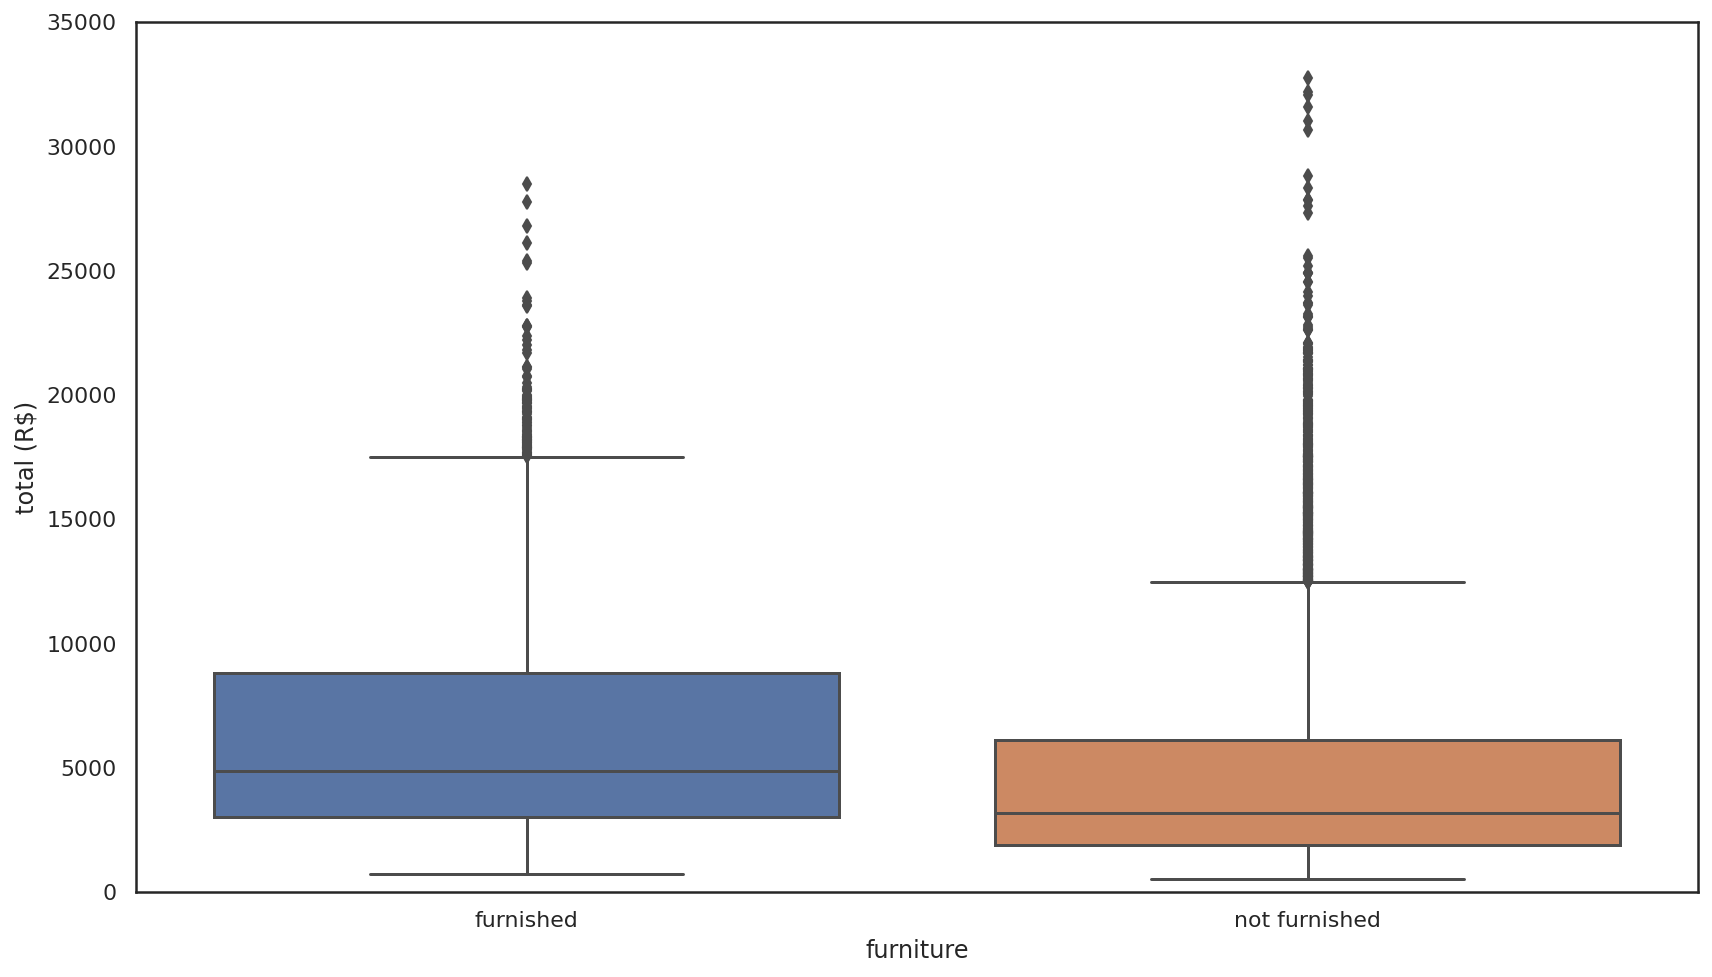

In [44]:
var = 'furniture'
data = pd.concat([df_clean_v2['total (R$)'], df_clean_v2[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v2)
fig.axis(ymin=0, ymax=35000);

### Bathrooms vs Price

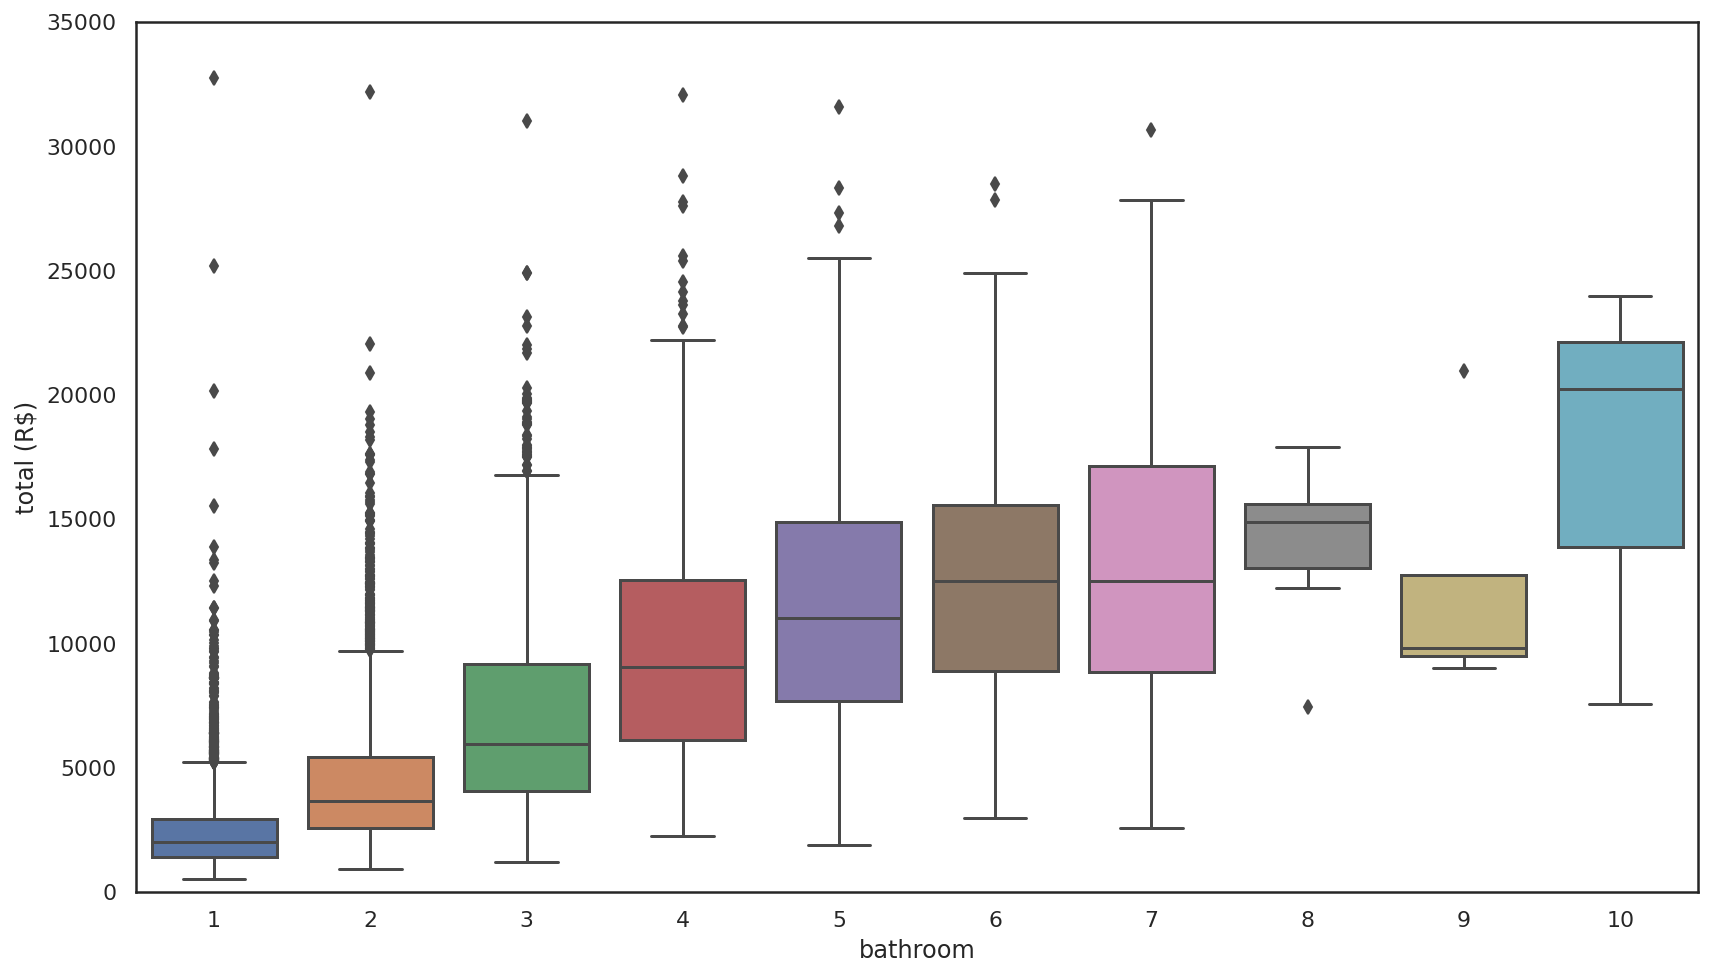

In [45]:
var = 'bathroom'
data = pd.concat([df_clean_v2['total (R$)'], df_clean_v2[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v2)
fig.axis(ymin=0, ymax=35000);

### Parking spaces vs Price

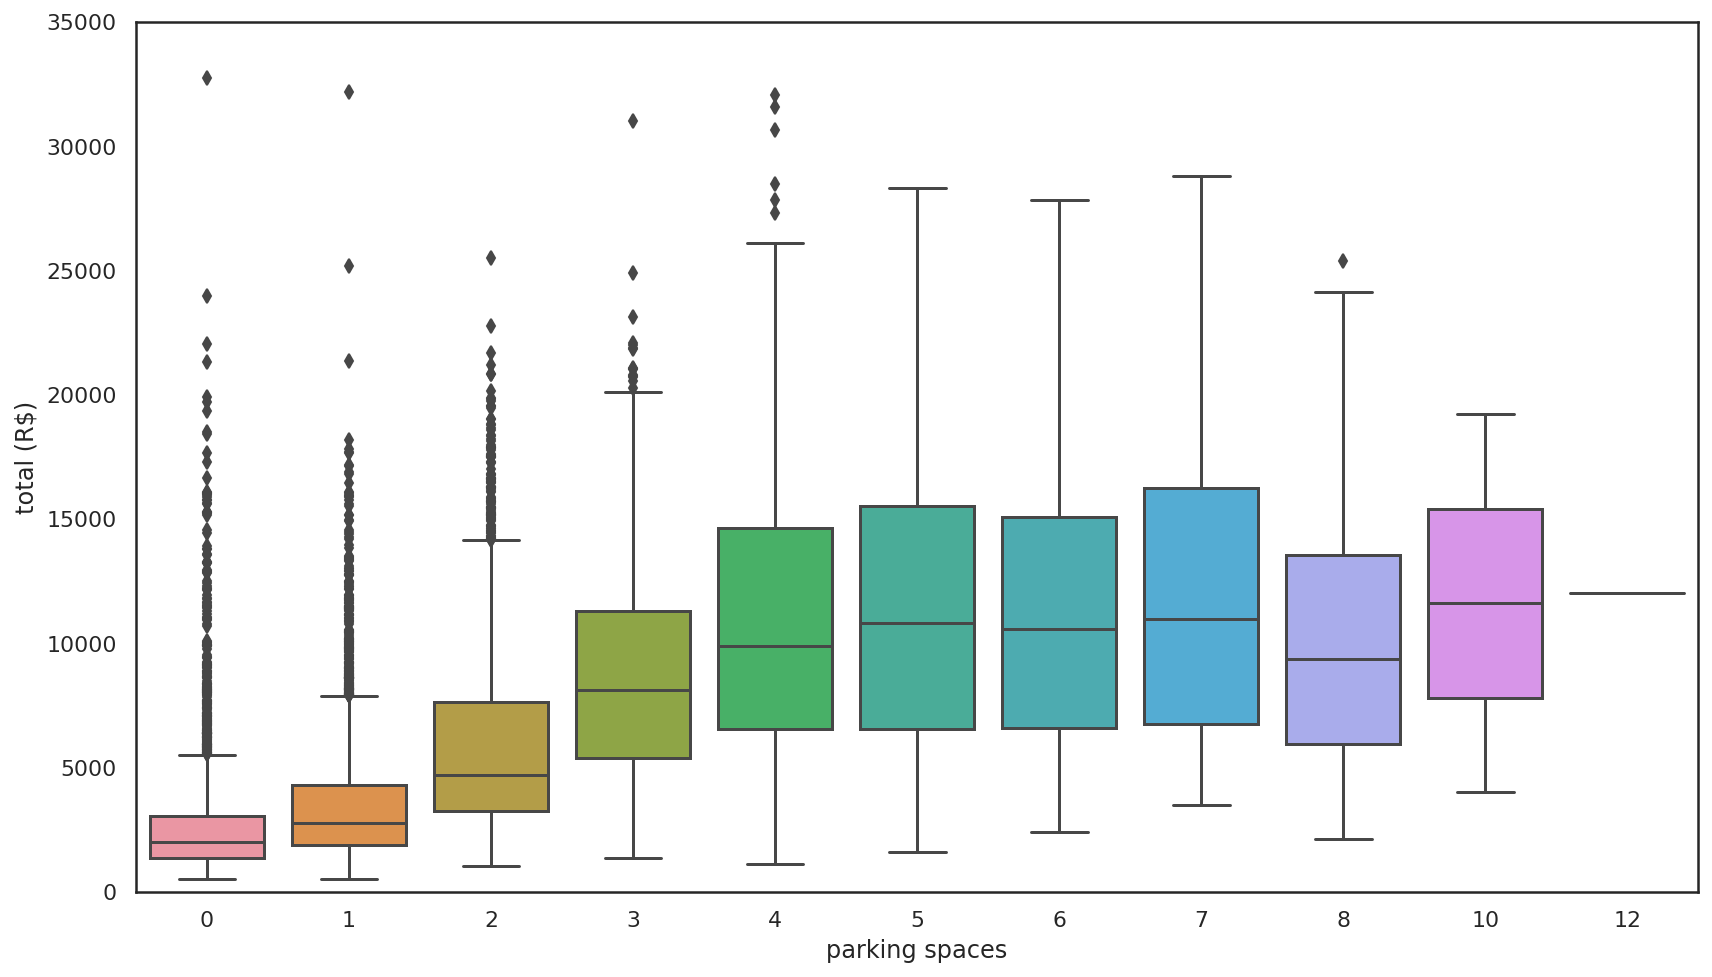

In [46]:
var = 'parking spaces'
data = pd.concat([df_clean_v2['total (R$)'], df_clean_v2[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="total (R$)", data=df_clean_v2)
fig.axis(ymin=0, ymax=35000);

### Summary

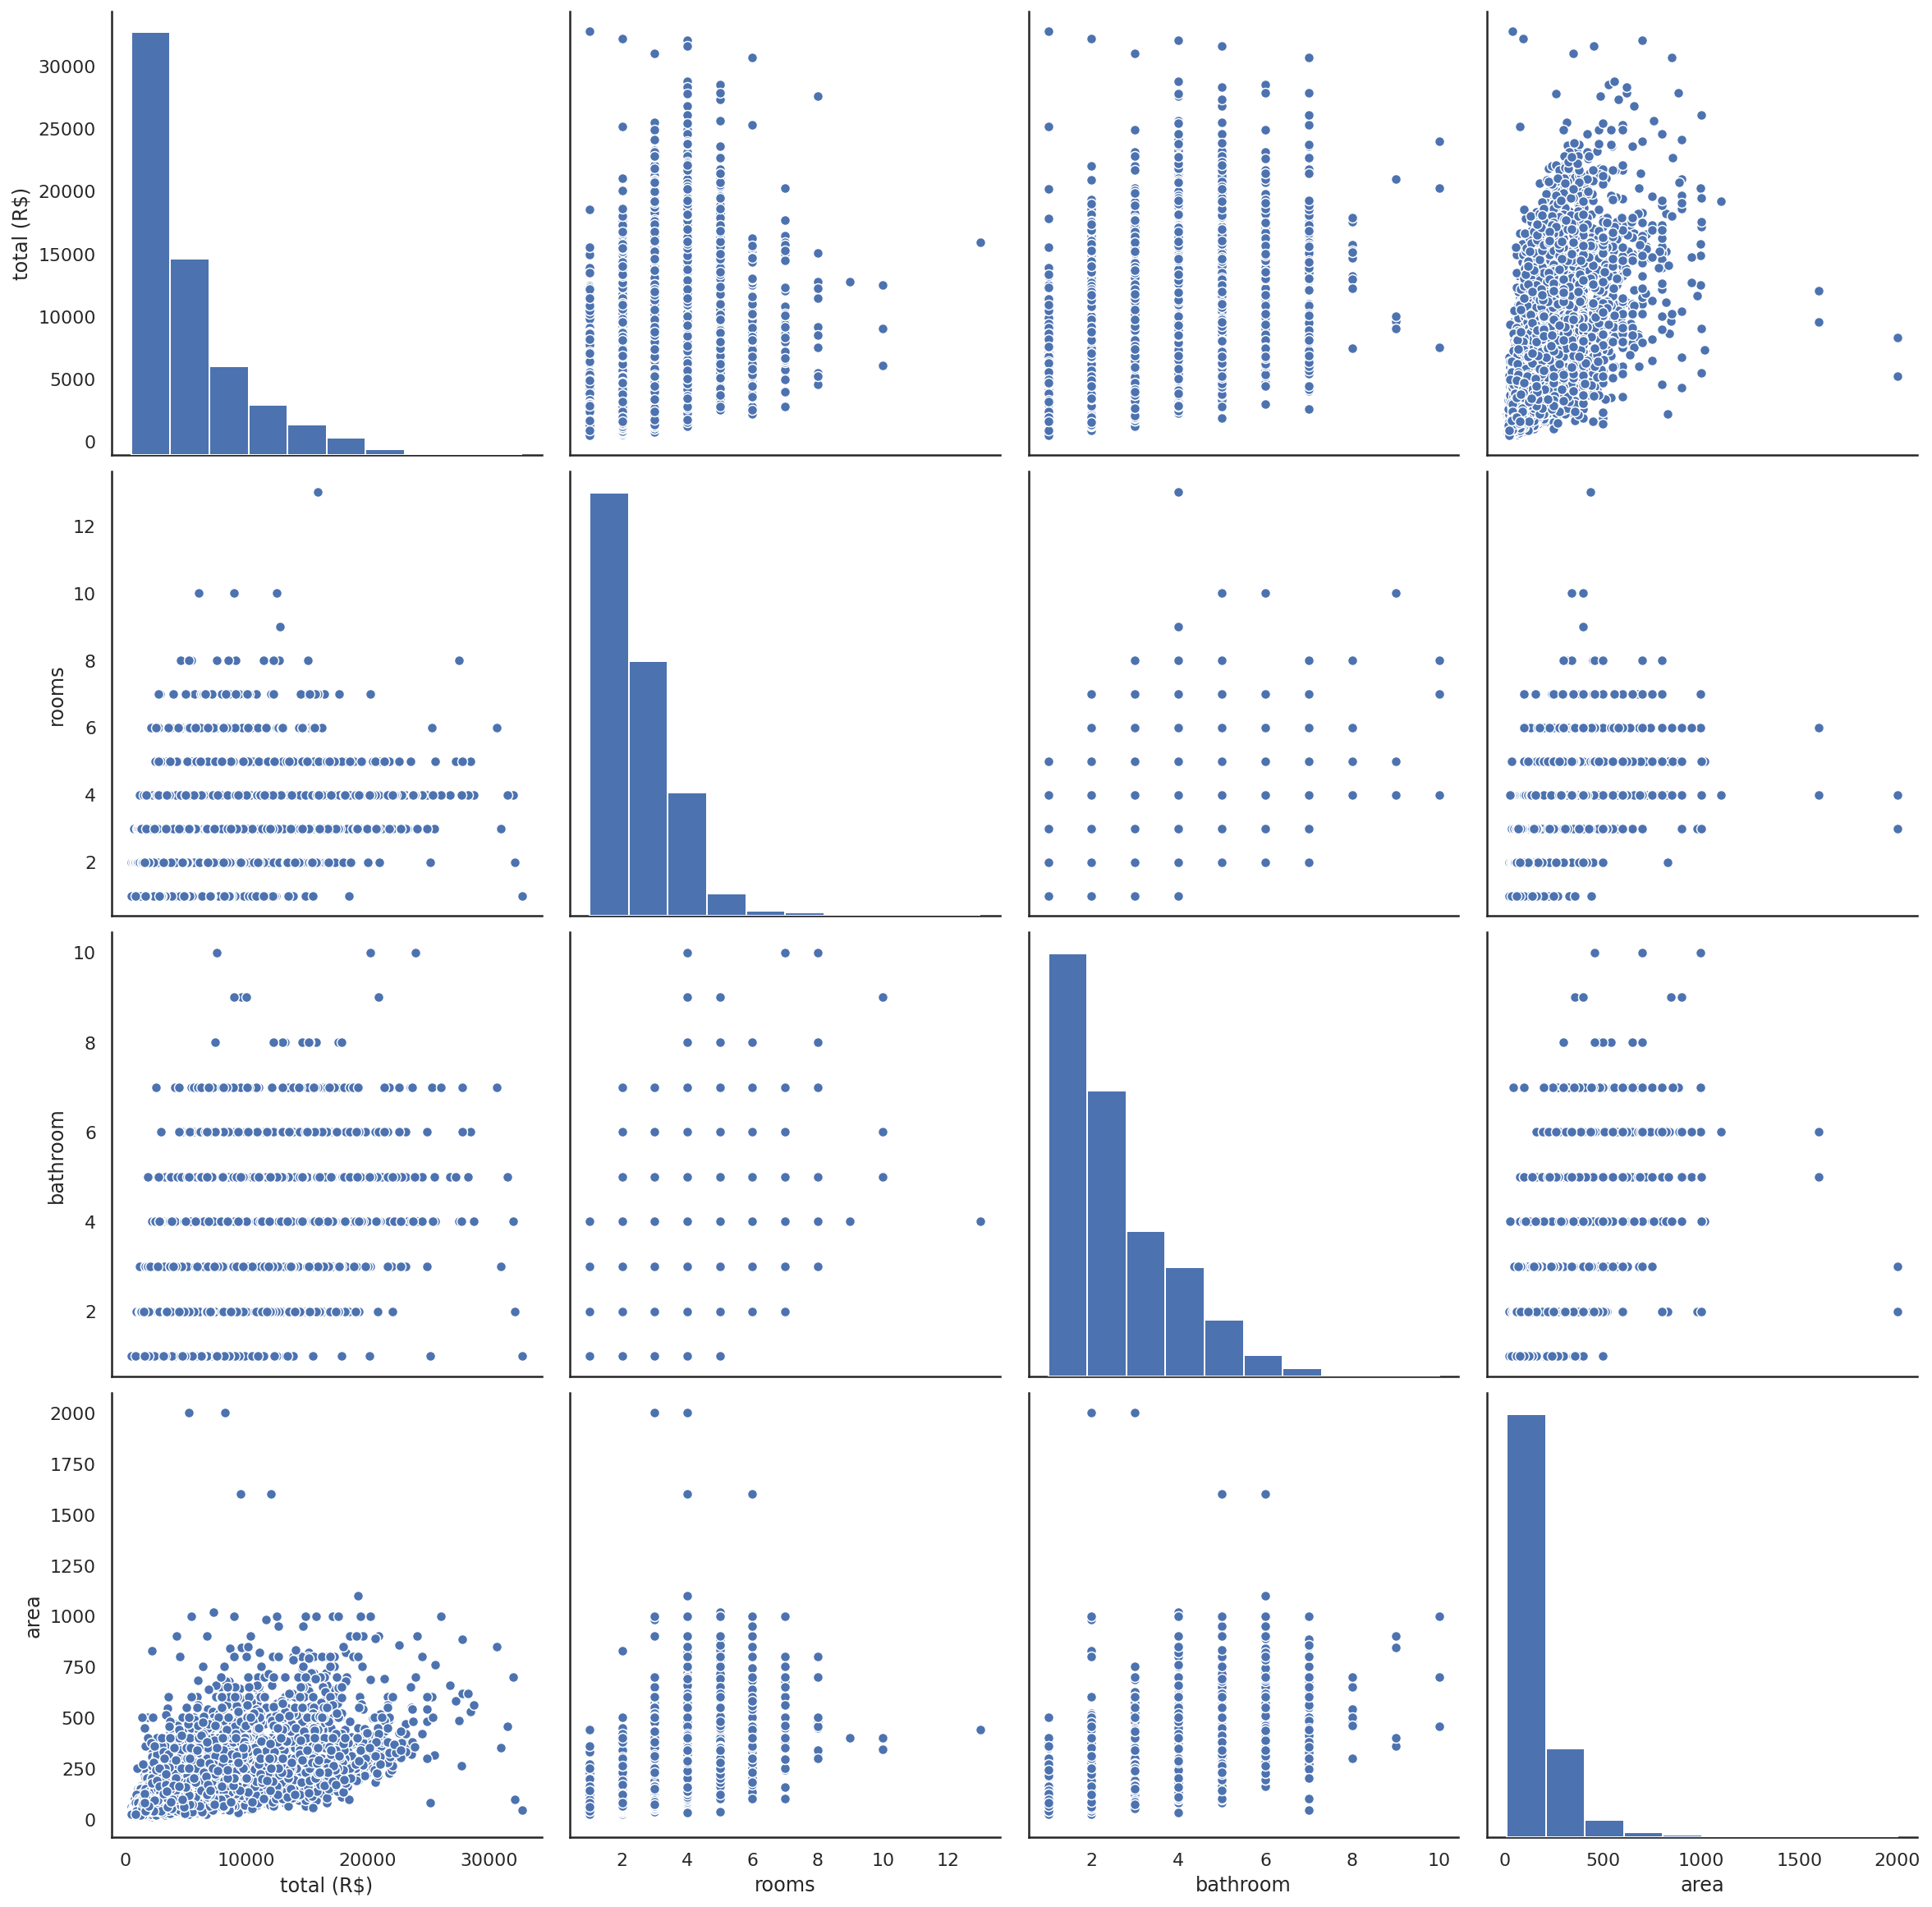

In [47]:
cols = ['total (R$)', 'rooms', 'bathroom', 'area']
sns.pairplot(df_clean_v2[cols], size = 4);

### Correlation matrix

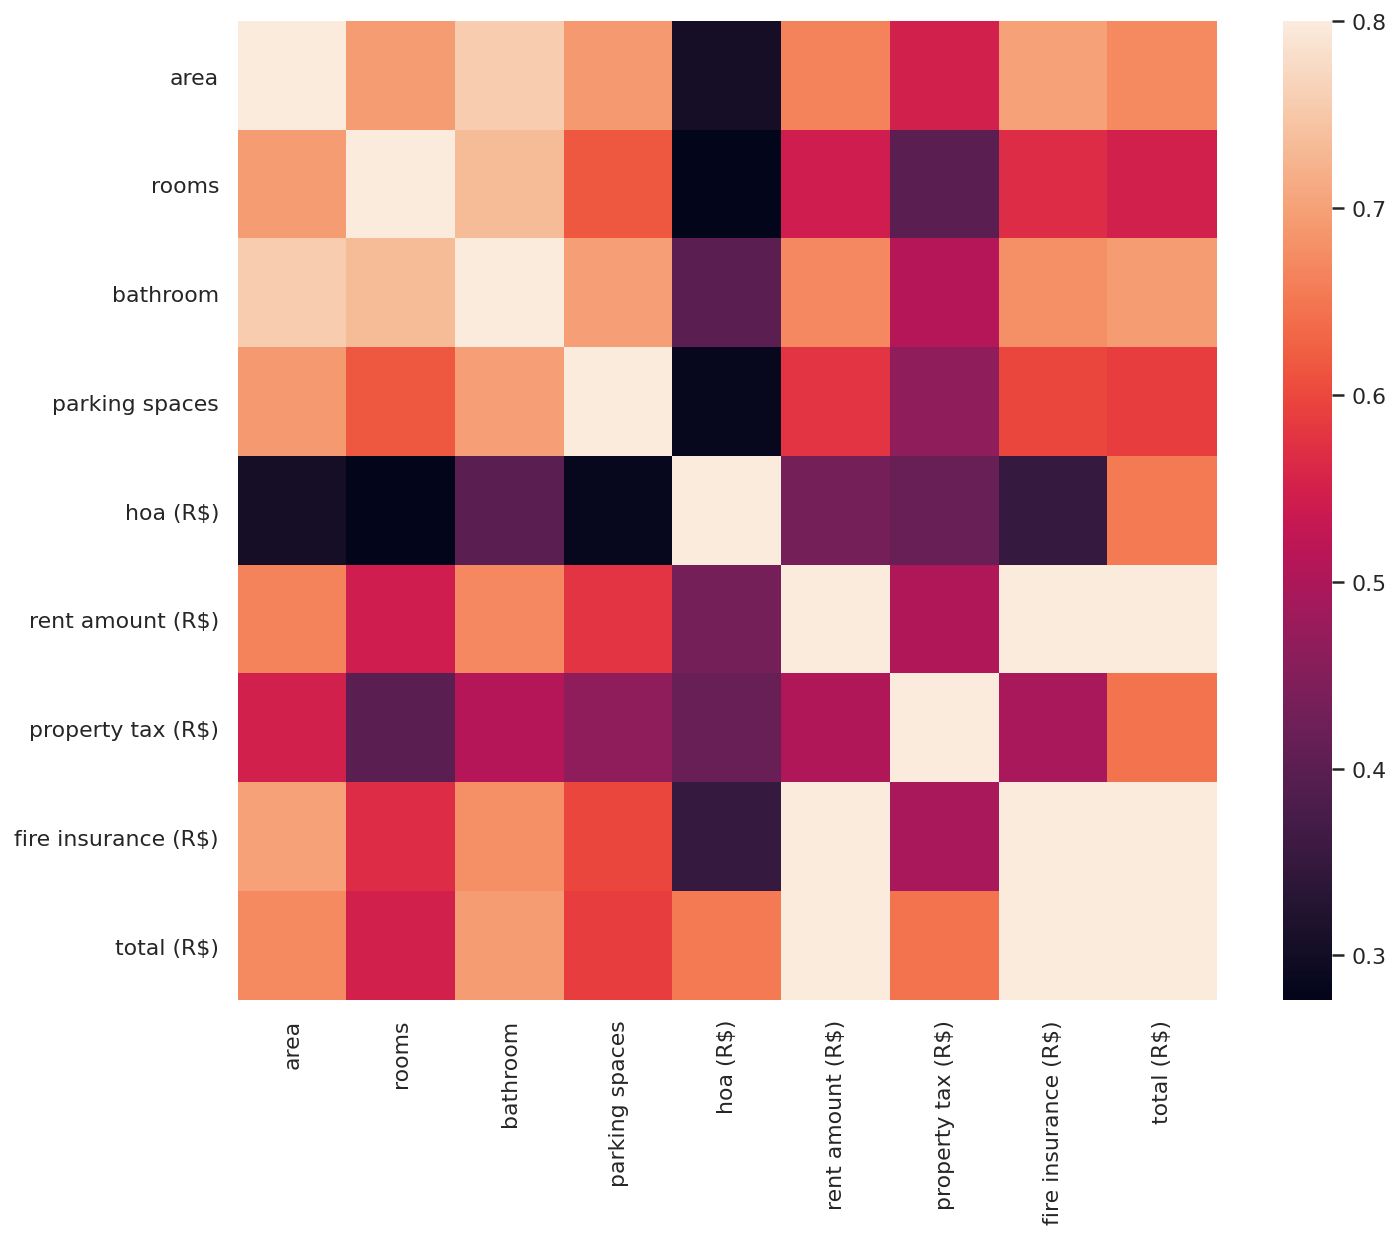

In [48]:
corrmat = df_clean_v2.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

# TRaining the model

We want to predict the price (number)

In [49]:
X = df_clean_v2.drop('total (R$)',axis =1)
X.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11


In [50]:
y = df_clean_v2['total (R$)']
y.head()

0    5618
1    7973
2    3841
3    1421
4     836
Name: total (R$), dtype: int64

Let's transofrm the categorical data into number in order to our model understand

In [51]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ['city','rooms','bathroom','parking spaces','floor','animal','furniture']
one_hot = OneHotEncoder()
transformer = ColumnTransformer([('one_hot',one_hot,categorical_features)],remainder = 'passthrough')
transformed_X = transformer.fit_transform(X)
transformed_X

<10682x81 sparse matrix of type '<class 'numpy.float64'>'
	with 124216 stored elements in Compressed Sparse Row format>

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(transformed_X,y,test_size = 0.2, random_state = 0)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_reg = reg.predict(X_test)
reg.score(X_test,y_test)

0.9999996257460111

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)
y_ridge = ridge.predict(X_test)
ridge.score(X_test,y_test)

0.9999961928435727

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
rf.score(X_test,y_test)

0.9752965481079127

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha = 1)
ridge.fit(X_train,y_train)
print(ridge.score(X_train, y_train))
print(ridge.score(X_test, y_test))

0.9999945123968371
0.9999961928435727


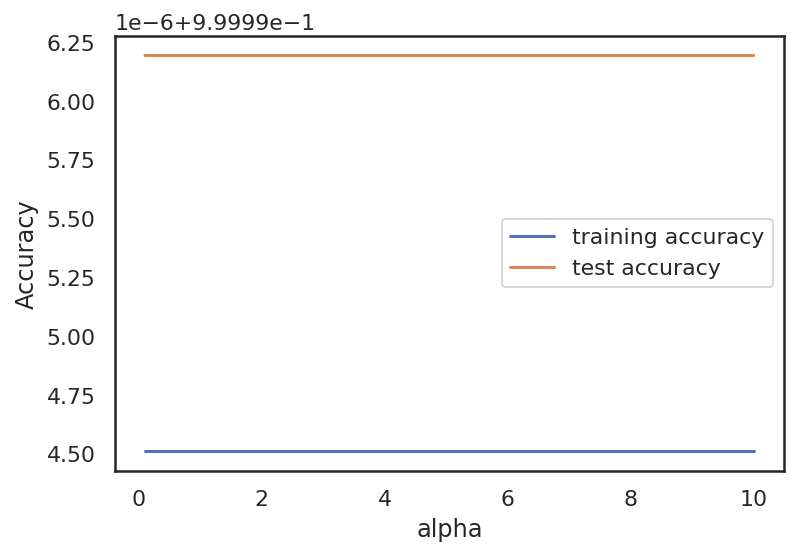

In [ ]:
alpha = [0.1, 1, 10]
training_accuracy = []
test_accuracy = []

for a in alpha:

  ridge = Ridge(alpha = a)
  ridge.fit(X_train,y_train)
  training_accuracy.append(ridge.score(X_train, y_train))
  test_accuracy.append(ridge.score(X_test, y_test))

plt.plot(alpha, training_accuracy, label="training accuracy")
plt.plot(alpha, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("alpha")
plt.legend()
  

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
classification_report(y_test,y_pred)

ValueError: ignored

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# São Paulo

In [ ]:
df_sp = df_clean_v2[df_clean_v2['city'] == 'São Paulo']
df_sp.head(5)

# Belo Horizonte

In [ ]:
df_bh = df_clean_v2[df_clean_v2['city'] == 'Belo Horizonte']
df_bh.head(5)

# Porto Alegre

In [ ]:
df_poa = df_clean_v2[df_clean_v2['city'] == 'Porto Alegre']
df_poa.head(5)

# Campinas

In [ ]:
df_camp = df_clean_v2[df_clean_v2['city'] == 'Campinas']
df_camp.head(5)

# Rio de Janeiro

In [ ]:
df_rj = df_clean_v2[df_clean_v2['city'] == 'Rio de Janeiro']
df_rj.head(5)